# Setting Up GPU and ML Management Tools

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from comet_ml import Experiment
import wandb

# Importing Modules

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from joblib import dump, load
from  IPython import display
import shutil
import tempfile
import pathlib
import sys

# This allows us to import the nucml utilities
sys.path.append("..")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
import nucml.exfor.data_utilities as exfor_utils
import nucml.endf.data_utilities as endf_utils
import nucml.plot.plotting_utilities as plot_utils
import nucml.datasets as nuc_data
import nucml.ace.data_utilities as ace_utils
import nucml.model.model_building_nn as model_tools
importlib.reload(model_tools)
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
importlib.reload(nuc_data)
importlib.reload(ace_utils)
print("Finish importing scripts.")

Finish importing scripts.


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir testing_logs --port 6007

# Loading EXFOR data

In [6]:
df, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_exfor(log=True, basic=0, num=True, low_en=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_NaNRaw.csv
Reading data into dataframe...
 MODE: neutrons
 LOW ENERGY: True
 LOG: True
 BASIC: 0
Data read into dataframe with shape:  (4184245, 10)
Dropping unnecessary features and one-hot encoding categorical columns...
Splitting dataset into training and testing...
Normalizing dataset...
Finished. Resulting dataset has shape  (4184245, 49) 
Training and Testing dataset shapes are (3765820, 48) and (418425, 48) respesctively.


In [7]:
nn_saving_dir = '../ML_Data/Models/NN/'

dump(scaler, open(os.path.join(nn_saving_dir, 'scaler.pkl'), 'wb'))

# Sampling Chlorine (n,p) and U-233(n,f) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [8]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}

chlorine_35_np = exfor_utils.load_exfor_samples(df, 17, 35, "MT_103", **kwargs)
uranium_235_nt = exfor_utils.load_exfor_samples(df, 92, 235, "MT_1", **kwargs)
uranium_233_nf = exfor_utils.load_exfor_samples(df, 92, 233, "MT_18", **kwargs)
uranium_233_nt = exfor_utils.load_exfor_samples(df, 92, 233, "MT_1", one_hot=True)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (40108, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (33384, 49)


In [9]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}
uranium = exfor_utils.load_exfor_element(df, 92, **kwargs)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (468123, 49)


# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [10]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":False, "scaler":scaler, "to_scale":to_scale}
new_cl_data = exfor_utils.load_exfor_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, **new_cl_data_kwargs)
new_cl_data.head()

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 49)
Expanded Dataset has shape:  (12, 49)


,Energy,Data,Target_Protons,Target_Neutrons,Target_Mass_Number,MT_1,MT_102,MT_16,MT_17,MT_2,MT_3,MT_4,MT_101,MT_103,MT_104,MT_41,MT_9000,MT_105,MT_32,MT_51,MT_33,MT_107,MT_24,MT_155,MT_158,MT_159,MT_108,MT_29,MT_1108,MT_113,MT_106,MT_22,MT_1003,MT_9001,MT_28,MT_111,MT_203,MT_2103,MT_112,MT_37,MT_161,MT_152,MT_153,MT_18,MT_160,Frame_L,Frame_C,Target_Flag_I,Target_Flag_N
0,6.383815,-1.779892,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,6.383815,-1.707744,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,6.401401,-1.583359,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,6.401401,-1.590067,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,6.411620,-1.350665,17,18,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [11]:
# ENDF EXTRACTION IMPLEMENTED INTO ANOTHER FUNCTION, NO NEED TO OBTAIN MANUALLY IN FUTURE VERSIONS

endf_cl = nuc_data.load_endf("Cl035", "MT103", log=True)
endf_u  = nuc_data.load_endf("U233", "MT018", log=True)
endf_cl_37 = nuc_data.load_endf("Cl037", "MT102", log=True)
endf_fe_56 = nuc_data.load_endf("Fe056", "MT002", log=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\Cl035\endfb8.0\tables\xs\n-Cl035-MT103.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (8791, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT018.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (15345, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\Cl037\endfb8.0\tables\xs\n-Cl037-MT102.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (20121, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\Fe056\endfb8.0\tables\xs\n-Fe056-MT002.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (46021, 2)


# Reading ACE Energies

In [12]:
# ACE EXTRACTION IMPLEMENTED INTO ANOTHER FUNCTION, NO NEED TO OBTAIN MANUALLY IN FUTURE VERSIONS

ace_u = ace_utils.get_energies("92233", ev=True, log=True)
ace_cl = ace_utils.get_energies("17035", ev=True, log=True)
ace_cl_37 = ace_utils.get_energies("17037", ev=True, log=True)
ace_fe_56 = ace_utils.get_energies("26056", ev=True, log=True)

# Using TensorFlow

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
print(tf.__version__)

2.1.0


In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Setting up Output Folder for Checkpoints and Checkpoint Callback

In [ ]:
wandb.init(project="ml-nuclear-data", name="test1", sync_tensorboard=True)
os.environ['WANDB_NOTEBOOK_NAME'] = '5_NN_EXFOR_v1_basics_neutrons'

In [15]:
histories = {}

In [17]:
x_train_t = x_train[:10000]
y_train_t = y_train[:10000]
x_test_t = x_test[:10000]
y_test_t = y_test[:10000]

In [ ]:
BATCH_SIZE = 500
EPOCHS = 20
ACTIVATION = "relu"
OPTIMIZER = "ITD"
DECAY_EPOCHS = 10
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
BASE_LOGGING_DIR_NAME = "testing_logs"

# THIS IS FOR COMMET
params={'Batch_Size':BATCH_SIZE,
        'Epochs':EPOCHS,
        'Activation':ACTIVATION,
        'Optimizer':OPTIMIZER,
        'Decay_Epochs':DECAY_EPOCHS,
        'Steps_per_Epoch':STEPS_PER_EPOCH
}

In [ ]:
histories['Tiny'] = model_tools.compile_and_fit(model, 'Tiny', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

In [ ]:
for num_layers_to_try in np.linspace(6,10, 5, dtype=int): # FOR 1 TO 5 LAYERS   
    for num_units in [600, 700, 800, 900, 1000]:  # FOR 100 TO 500 NEURONS
        model = tf.keras.Sequential()    # INITIALIZE MODEL
        for num_layers in np.linspace(1, num_layers_to_try, num_layers_to_try, dtype=int):
            model.add(tf.keras.layers.Dense(num_units, activation='relu'))
            params["Layer_{}_Units".format(num_layers)] = num_units
        model.add(tf.keras.layers.Dense(1))
        params["Layer_{}_Units".format(num_layers + 1)] = 1
        params["Number_of_Layers"] = num_layers + 1
        model.build((None, 48))
        model.summary()
        
        histories['{}_Layers_{}_Units'.format(num_layers_to_try, num_units)] = model_tools.compile_and_fit(
            model, '{}_Layers_{}_Units'.format(num_layers_to_try, num_units), 
            x_train_t.values, y_train_t.values, x_test_t.values, y_test_t.values, 
            BATCH_SIZE=BATCH_SIZE, max_epochs=EPOCHS, DECAY_EPOCHS=DECAY_EPOCHS, lr_method=OPTIMIZER, 
            logs_dir_name=BASE_LOGGING_DIR_NAME, wandb=True)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

In [21]:
model.layers[0].units

500

In [24]:
importlib.reload(model_tools)

<module 'nucml.model.model_building_nn' from '..\\nucml\\model\\model_building_nn.py'>

In [ ]:
iteration_name = "test1"

wandb.init(project="ml-nuclear-data", name="test1", sync_tensorboard=True)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['Tiny'] = model_tools.compile_and_fit(model, 'Tiny', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

In [120]:
histories['Tiny'] = model_tools.compile_and_fit(model, 'Tiny', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764400/3765820 [============================>.] - ETA: 0s - loss: 0.2808 - mae: 0.3224 - mse: 0.2808
Epoch: 0, loss:0.2808,  mae:0.3224,  mse:0.2808,  val_loss:0.2581,  val_mae:0.2997,  val_mse:0.2581,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1586 - mae: 0.2304 - mse: 0.1586 - val_loss: 0.1151 - val_mae: 0.2062 - val_mse: 0.1151Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1503 - mae: 0.2247 - mse: 0.1503 - val_loss: 0.3193 - val_mae: 0.2791 - val_mse: 0.3193

In [125]:
histories['Tiny_ITD'] = model_tools.compile_and_fit(model, 'Tiny_ITD', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764400/3765820 [============================>.] - ETA: 0s - loss: 0.1604 - mae: 0.2294 - mse: 0.1604
Epoch: 0, loss:0.1604,  mae:0.2295,  mse:0.1604,  val_loss:0.1946,  val_mae:0.2469,  val_mse:0.1946,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0915 - mae: 0.1756 - mse: 0.0915 - val_loss: 0.0924 - val_mae: 0.1768 - val_mse: 0.0924Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0869 - mae: 0.1697 - mse: 0.0869 - val_loss: 0.0866 - val_mae: 0.1693 - val_mse: 0.0866

In [126]:
histories['Tiny_Plateau'] = model_tools.compile_and_fit(model, 'Tiny_Plateau', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="plateau")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762600/3765820 [============================>.] - ETA: 0s - loss: 0.1495 - mae: 0.2244 - mse: 0.1495
Epoch: 0, loss:0.1495,  mae:0.2244,  mse:0.1495,  val_loss:0.1599,  val_mae:0.2275,  val_mse:0.1599,  
3763720/3765820 [============================>.] - ETA: 0s - loss: 0.1802 - mae: 0.2377 - mse: 0.1802.
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
3763420/3765820 [============================>.] - ETA: 0s - loss: 0.1329 - mae: 0.2098 - mse: 0.1329.
Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
3764020/3765820 [============================>.] - ETA: 0s - loss: 0.1341 - mae: 0.2110 - mse: 0.1341.
Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
3764620/3765820 [============================>.] - ETA: 0s - loss: 0.1092 - mae: 0.1946 - mse: 0.1092.
Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815

3763420/3765820 [============================>.] - ETA: 0s - loss: 0.0903 - mae: 0.1736 - mse: 0.0903.
Epoch 00098: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0892 - mae: 0.1721 - mse: 0.0892 - val_loss: 0.0894 - val_mae: 0.1732 - val_mse: 0.0894

In [127]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

histories['Medium_ITD'] = model_tools.compile_and_fit(medium_model, 'Medium_ITD', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765300/3765820 [============================>.] - ETA: 0s - loss: 0.2881 - mae: 0.3309 - mse: 0.2881
Epoch: 0, loss:0.2881,  mae:0.3309,  mse:0.2881,  val_loss:0.2569,  val_mae:0.3102,  val_mse:0.2569,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1162 - mae: 0.2084 - mse: 0.1162 - val_loss: 0.1156 - val_mae: 0.2077 - val_mse: 0.1156Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1112 - mae: 0.2028 - mse: 0.1112 - val_loss: 0.1106 - val_mae: 0.2030 - val_mse: 0.1106

In [128]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD'] = model_tools.compile_and_fit(large_model, 'Large_ITD', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765600/3765820 [============================>.] - ETA: 0s - loss: 0.2736 - mae: 0.3173 - mse: 0.2736
Epoch: 0, loss:0.2736,  mae:0.3173,  mse:0.2736,  val_loss:0.2419,  val_mae:0.2912,  val_mse:0.2419,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0988 - mae: 0.1856 - mse: 0.0988 - val_loss: 0.0986 - val_mae: 0.1860 - val_mse: 0.0986Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0922 - mae: 0.1771 - mse: 0.0922 - val_loss: 0.0925 - val_mae: 0.1778 - val_mse: 0.0925

In [147]:
large_model_exp = tf.keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_Exp'] = model_tools.compile_and_fit(large_model_exp, 'Large_ITD_Exp', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765000/3765820 [============================>.] - ETA: 0s - loss: 0.2777 - mae: 0.3200 - mse: 0.2777
Epoch: 0, loss:0.2777,  mae:0.3199,  mse:0.2777,  val_loss:0.2722,  val_mae:0.2993,  val_mse:0.2722,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0958 - mae: 0.1800 - mse: 0.0959 - val_loss: 0.0953 - val_mae: 0.1805 - val_mse: 0.0953Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0829 - mae: 0.1642 - mse: 0.0829 - val_loss: 0.0823 - val_mae: 0.1634 - val_mse: 0.0823

In [148]:
large_model_exp_2 = tf.keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_Exp_2'] = model_tools.compile_and_fit(large_model_exp_2, 'Large_ITD_Exp_2', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763800/3765820 [============================>.] - ETA: 0s - loss: 0.2836 - mae: 0.3247 - mse: 0.2836
Epoch: 0, loss:0.2836,  mae:0.3247,  mse:0.2836,  val_loss:0.2725,  val_mae:0.3276,  val_mse:0.2725,  
3098020/3765820 [=======================>......] - ETA: 13s - loss: 0.1046 - mae: 0.1890 - mse: 0.1046

KeyboardInterrupt: 

In [30]:
large_model_exp_1000 = tf.keras.Sequential([
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_Exp_1000'] = model_tools.compile_and_fit(large_model_exp_1000, 'Large_ITD_Exp_1000', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764700/3765820 [============================>.] - ETA: 0s - loss: 0.2816 - mae: 0.3222 - mse: 0.2816
Epoch: 0, loss:0.2816,  mae:0.3222,  mse:0.2816,  val_loss:0.2518,  val_mae:0.2984,  val_mse:0.2518,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0979 - mae: 0.1813 - mse: 0.0979 - val_loss: 0.0965 - val_mae: 0.1794 - val_mse: 0.0965Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0854 - mae: 0.1665 - mse: 0.0854 - val_loss: 0.0866 - val_mae: 0.1676 - val_mse: 0.0866

In [32]:
large_model_red = tf.keras.Sequential([
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_Red'] = model_tools.compile_and_fit(large_model_red, 'Large_ITD_Red', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765300/3765820 [============================>.] - ETA: 0s - loss: 0.2788 - mae: 0.3203 - mse: 0.2788
Epoch: 0, loss:0.2788,  mae:0.3203,  mse:0.2788,  val_loss:0.2683,  val_mae:0.3033,  val_mse:0.2683,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0995 - mae: 0.1836 - mse: 0.0995 - val_loss: 0.0971 - val_mae: 0.1816 - val_mse: 0.0971Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0853 - mae: 0.1677 - mse: 0.0853 - val_loss: 0.0855 - val_mae: 0.1666 - val_mse: 0.0855

In [33]:
large_model_2000 = tf.keras.Sequential([
    layers.Dense(2000, activation='relu'),
    layers.Dense(2000, activation='relu'),
    layers.Dense(2000, activation='relu'),
    layers.Dense(2000, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_2000'] = model_tools.compile_and_fit(large_model_2000, 'Large_ITD_2000', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764100/3765820 [============================>.] - ETA: 0s - loss: 0.2818 - mae: 0.3224 - mse: 0.2818
Epoch: 0, loss:0.2818,  mae:0.3224,  mse:0.2818,  val_loss:0.2184,  val_mae:0.2793,  val_mse:0.2184,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0984 - mae: 0.1844 - mse: 0.0984 - val_loss: 0.1068 - val_mae: 0.1916 - val_mse: 0.1068Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0921 - mae: 0.1763 - mse: 0.0921 - val_loss: 0.0935 - val_mae: 0.1774 - val_mse: 0.0935

In [34]:
model_v1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['bTiny_v1'] = model_tools.compile_and_fit(model_v1, 'bTiny_v1', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764400/3765820 [============================>.] - ETA: 0s - loss: 0.3064 - mae: 0.3368 - mse: 0.3064
Epoch: 0, loss:0.3063,  mae:0.3368,  mse:0.3063,  val_loss:0.2654,  val_mae:0.3099,  val_mse:0.2654,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1309 - mae: 0.2149 - mse: 0.1309 - val_loss: 0.1195 - val_mae: 0.2059 - val_mse: 0.1195Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1340 - mae: 0.2162 - mse: 0.1340 - val_loss: 0.1183 - val_mae: 0.2067 - val_mse: 0.1183

In [35]:
model_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(2, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['bTiny_v2'] = model_tools.compile_and_fit(model_v2, 'bTiny_v2', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763800/3765820 [============================>.] - ETA: 0s - loss: 0.7946 - mae: 0.5913 - mse: 0.7946
Epoch: 0, loss:0.7946,  mae:0.5913,  mse:0.7946,  val_loss:0.7794,  val_mae:0.5803,  val_mse:0.7794,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.7819 - mae: 0.5810 - mse: 0.7819 - val_loss: 0.7793 - val_mae: 0.5800 - val_mse: 0.7793Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.7820 - mae: 0.5810 - mse: 0.7820 - val_loss: 0.7794 - val_mae: 0.5799 - val_mse: 0.7794

In [36]:
model_asym = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['basym'] = model_tools.compile_and_fit(model_asym, 'basym', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763200/3765820 [============================>.] - ETA: 0s - loss: 0.2830 - mae: 0.3233 - mse: 0.2830
Epoch: 0, loss:0.2829,  mae:0.3233,  mse:0.2829,  val_loss:0.2551,  val_mae:0.3037,  val_mse:0.2551,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1809 - mae: 0.2466 - mse: 0.1809 - val_loss: 0.1538 - val_mae: 0.2310 - val_mse: 0.1538Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1632 - mae: 0.2351 - mse: 0.1632 - val_loss: 0.2667 - val_mae: 0.2763 - val_mse: 0.2667

In [37]:
model_sym = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)])

histories['bsym'] = model_tools.compile_and_fit(model_sym, 'bsym', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763200/3765820 [============================>.] - ETA: 0s - loss: 0.2831 - mae: 0.3233 - mse: 0.2831
Epoch: 0, loss:0.2831,  mae:0.3232,  mse:0.2831,  val_loss:0.2538,  val_mae:0.2982,  val_mse:0.2538,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1694 - mae: 0.2309 - mse: 0.1694 - val_loss: 0.1523 - val_mae: 0.2185 - val_mse: 0.1523Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1095 - mae: 0.1975 - mse: 0.1095 - val_loss: 0.1056 - val_mae: 0.1941 - val_mse: 0.1056

In [38]:
model_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(900, activation='relu'), 
    tf.keras.layers.Dense(800, activation='relu'), 
    tf.keras.layers.Dense(700, activation='relu'), 
    tf.keras.layers.Dense(600, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(2, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['bTiny_v3'] = model_tools.compile_and_fit(model_v3, 'bTiny_v3', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765000/3765820 [============================>.] - ETA: 0s - loss: 0.3233 - mae: 0.3496 - mse: 0.3233
Epoch: 0, loss:0.3233,  mae:0.3496,  mse:0.3233,  val_loss:0.2807,  val_mae:0.3234,  val_mse:0.2807,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1364 - mae: 0.2190 - mse: 0.1364 - val_loss: 0.1298 - val_mae: 0.2148 - val_mse: 0.1298Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1177 - mae: 0.2048 - mse: 0.1177 - val_loss: 0.1169 - val_mae: 0.2037 - val_mse: 0.1169

In [39]:
large_model = tf.keras.Sequential([
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_100'] = model_tools.compile_and_fit(large_model, 'Large_ITD_100', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765300/3765820 [============================>.] - ETA: 0s - loss: 0.2787 - mae: 0.3225 - mse: 0.2787
Epoch: 0, loss:0.2787,  mae:0.3225,  mse:0.2787,  val_loss:0.2482,  val_mae:0.3016,  val_mse:0.2482,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1043 - mae: 0.1936 - mse: 0.1043 - val_loss: 0.1054 - val_mae: 0.1942 - val_mse: 0.1054Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0990 - mae: 0.1870 - mse: 0.0990 - val_loss: 0.1001 - val_mae: 0.1879 - val_mse: 0.1001

In [40]:
large_model = tf.keras.Sequential([
    layers.Dense(200, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_200'] = model_tools.compile_and_fit(large_model, 'Large_ITD_200', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764400/3765820 [============================>.] - ETA: 0s - loss: 0.2733 - mae: 0.3174 - mse: 0.2733
Epoch: 0, loss:0.2733,  mae:0.3174,  mse:0.2733,  val_loss:0.2379,  val_mae:0.2900,  val_mse:0.2379,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1001 - mae: 0.1875 - mse: 0.1001 - val_loss: 0.1000 - val_mae: 0.1865 - val_mse: 0.1000Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0950 - mae: 0.1809 - mse: 0.0950 - val_loss: 0.0952 - val_mae: 0.1806 - val_mse: 0.0952

In [41]:
large_model = tf.keras.Sequential([
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_300'] = model_tools.compile_and_fit(large_model, 'Large_ITD_300', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765000/3765820 [============================>.] - ETA: 0s - loss: 0.2738 - mae: 0.3177 - mse: 0.2738
Epoch: 0, loss:0.2738,  mae:0.3177,  mse:0.2738,  val_loss:0.2664,  val_mae:0.2992,  val_mse:0.2664,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0999 - mae: 0.1874 - mse: 0.0999 - val_loss: 0.0989 - val_mae: 0.1853 - val_mse: 0.0989Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0942 - mae: 0.1801 - mse: 0.0942 - val_loss: 0.0999 - val_mae: 0.1870 - val_mse: 0.0999

In [42]:
large_model = tf.keras.Sequential([
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(1)])

histories['Large_ITD_300e'] = model_tools.compile_and_fit(large_model, 'Large_ITD_300e', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763500/3765820 [============================>.] - ETA: 0s - loss: 0.2878 - mae: 0.3281 - mse: 0.2878
Epoch: 0, loss:0.2878,  mae:0.3281,  mse:0.2878,  val_loss:0.2441,  val_mae:0.3078,  val_mse:0.2441,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1049 - mae: 0.1892 - mse: 0.1049 - val_loss: 0.1060 - val_mae: 0.1912 - val_mse: 0.1060Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0908 - mae: 0.1742 - mse: 0.0908 - val_loss: 0.0919 - val_mae: 0.1737 - val_mse: 0.0919

In [77]:
for u in [100, 200, 300, 400, 500]:
    model = tf.keras.Sequential([
        layers.Dense(u, activation='relu'),
        layers.Dense(u, activation='relu'),
        layers.Dense(u, activation='relu'),
        layers.Dense(u, activation='relu'),
        layers.Dense(u, activation='relu'),
        layers.Dense(u, activation='relu'),
        layers.Dense(u, activation='relu'),
        layers.Dense(u, activation='relu'),
        layers.Dense(1)])

    histories['Large_ITD_Exp_{}'.format(u)] = model_tools.compile_and_fit(model, 'Large_ITD_Exp_{}'.format(u), x_train.values, y_train.values, 
                                                    x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                    DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765300/3765820 [============================>.] - ETA: 0s - loss: 0.2802 - mae: 0.3221 - mse: 0.2802
Epoch: 0, loss:0.2802,  mae:0.3221,  mse:0.2802,  val_loss:0.2701,  val_mae:0.3152,  val_mse:0.2701,  
2339920/3765820 [=================>............] - ETA: 23s - loss: 0.1075 - mae: 0.1946 - mse: 0.1075

KeyboardInterrupt: 

In [82]:
for num_layers_to_try in np.linspace(1,5, 5, dtype=int): # FOR 1 TO 5 LAYERS   
    for num_units in [100, 200, 300, 400, 500]:  # FOR 100 TO 500 NEURONS
        model = tf.keras.Sequential()    # INITIALIZE MODEL
        for num_layers in np.linspace(1, num_layers_to_try, num_layers_to_try, dtype=int):
            model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        model.build((None, 48))
        model.summary()
        
        histories['{}_Layers_{}_Units'.format(num_layers_to_try, num_units)] = model_tools.compile_and_fit(
            model, '{}_Layers_{}_Units'.format(num_layers_to_try, num_units), 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=100, DECAY_EPOCHS=10, lr_method="ITD")

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            multiple                  4900      
_________________________________________________________________
dense_266 (Dense)            multiple                  101       
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763200/3765820 [============================>.] - ETA: 0s - loss: 0.3183 - mae: 0.3551 - mse: 0.3183
Epoch: 0, loss:0.3183,  mae:0.3551,  mse:0.3183,  val_loss:0.3056,  val_mae:0.3506,  val_mse:0.3056,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2492 - mae: 0.3042 - mse: 0.2492 - val_loss: 0.2504 - val_mae: 0.3053 - val_mse: 0.2504Epoch 92/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2485 - mae: 0.3038 - mse: 0.2485 - val_loss: 0.2498 - val_mae: 0.3041 - val_mse: 0.2498Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_267 (Dense)            multiple                  9800      
_________________________________________________________________
dense_268 (Dense)            multiple                  201       
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765000/3765820 [============================>.] - ETA: 0s - loss: 0.3108 - mae: 0.3486 - mse: 0.3108
Epoch: 0, loss:0.3108,  mae:0.3486,  mse:0.3108,  val_loss:0.2941,  val_mae:0.3310,  val_mse:0.2941,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2329 - mae: 0.29

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2315 - mae: 0.2904 - mse: 0.2315 - val_loss: 0.2342 - val_mae: 0.2956 - val_mse: 0.2342Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_269 (Dense)            multiple                  14700     
_________________________________________________________________
dense_270 (Dense)            multiple                  301       
Total params: 15,001
Trainable params: 15,001
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3761700/3765820 [============================>.] - ETA: 0s - loss: 0.3084 - mae: 0.3477 - mse: 0.3084
Epoch: 0, loss:0.3084,  mae:0.3477,  mse:0.3084,  val_loss:0.2933,  val_mae:0.3384,  val_mse:0.2933,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2303 - mae: 0.29

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2277 - mae: 0.2887 - mse: 0.2277 - val_loss: 0.2307 - val_mae: 0.2938 - val_mse: 0.2307Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_271 (Dense)            multiple                  19600     
_________________________________________________________________
dense_272 (Dense)            multiple                  401       
Total params: 20,001
Trainable params: 20,001
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763500/3765820 [============================>.] - ETA: 0s - loss: 0.3074 - mae: 0.3471 - mse: 0.3074
Epoch: 0, loss:0.3074,  mae:0.3471,  mse:0.3074,  val_loss:0.2920,  val_mae:0.3333,  val_mse:0.2920,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2299 - mae: 0.28

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2247 - mae: 0.2844 - mse: 0.2247 - val_loss: 0.2269 - val_mae: 0.2863 - val_mse: 0.2269Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_273 (Dense)            multiple                  24500     
_________________________________________________________________
dense_274 (Dense)            multiple                  501       
Total params: 25,001
Trainable params: 25,001
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764700/3765820 [============================>.] - ETA: 0s - loss: 0.3067 - mae: 0.3466 - mse: 0.3067
Epoch: 0, loss:0.3067,  mae:0.3466,  mse:0.3067,  val_loss:0.2935,  val_mae:0.3386,  val_mse:0.2935,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2290 - mae: 0.28

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.2227 - mae: 0.2847 - mse: 0.2227 - val_loss: 0.2241 - val_mae: 0.2833 - val_mse: 0.2241Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_275 (Dense)            multiple                  4900      
_________________________________________________________________
dense_276 (Dense)            multiple                  10100     
_________________________________________________________________
dense_277 (Dense)            multiple                  101       
Total params: 15,101
Trainable params: 15,101
Non-trainable params: 0
_________________________________________________________________


Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765600/3765820 [============================>.] - ETA: 0s - loss: 0.3003 - mae: 0.3427 - mse: 0.3003
Epoch: 0, loss:0.3003,  mae:0.3427,  mse:0.3003,  val_loss:0.2758,  val_mae:0.3244,  val_mse:0.2758,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1380 - mae: 0.2285 - mse: 0.1380 - val_loss: 0.1366 - val_mae: 0.2271 - val_mse: 0.1366Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1232 - mae: 0.2166 - mse: 0.1232 - val_loss: 0.1230 - val_mae: 0.2168 - val_mse: 0.1230Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_278 (Dense)            multiple                  9800      
_________________________________________________________________
dense_279 (Dense)            multiple                  40200     
_________________________________________________________________
dense_280 (Dense)            multiple                  201       
Total params: 50,201
Trainable params: 50,201
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762600/3765820 [============================>.] - ETA: 0s - loss: 0.2883 - mae: 0.3318 - mse: 0.2883
Epoch: 0, loss:0.2883,  mae:0.3318,  mse:0.2883,  val_lo

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1105 - mae: 0.2021 - mse: 0.1105 - val_loss: 0.1122 - val_mae: 0.2033 - val_mse: 0.1122Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_281 (Dense)            multiple                  14700     
_________________________________________________________________
dense_282 (Dense)            multiple                  90300     
_________________________________________________________________
dense_283 (Dense)            multiple                  301       
Total params: 105,301
Trainable params: 105,301
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762600/3765820 [============================>.] - ETA: 0s - loss: 0.2846 - mae: 0.3291 - mse: 0.2846
Epoch: 0, loss:0.2846,  mae:0.3290,  mse:0.2846,  val_

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1103 - mae: 0.2013 - mse: 0.1103 - val_loss: 0.1106 - val_mae: 0.2011 - val_mse: 0.1106Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_284 (Dense)            multiple                  19600     
_________________________________________________________________
dense_285 (Dense)            multiple                  160400    
_________________________________________________________________
dense_286 (Dense)            multiple                  401       
Total params: 180,401
Trainable params: 180,401
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764700/3765820 [============================>.] - ETA: 0s - loss: 0.2839 - mae: 0.3284 - mse: 0.2839
Epoch: 0, loss:0.2839,  mae:0.3284,  mse:0.2839,  val_

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1088 - mae: 0.1989 - mse: 0.1088 - val_loss: 0.1091 - val_mae: 0.1991 - val_mse: 0.1091Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_287 (Dense)            multiple                  24500     
_________________________________________________________________
dense_288 (Dense)            multiple                  250500    
_________________________________________________________________
dense_289 (Dense)            multiple                  501       
Total params: 275,501
Trainable params: 275,501
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762600/3765820 [============================>.] - ETA: 0s - loss: 0.2821 - mae: 0.3268 - mse: 0.2821
Epoch: 0, loss:0.2821,  mae:0.3268,  mse:0.2821,  val_

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1073 - mae: 0.1972 - mse: 0.1073 - val_loss: 0.1077 - val_mae: 0.1965 - val_mse: 0.1077Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_290 (Dense)            multiple                  4900      
_________________________________________________________________
dense_291 (Dense)            multiple                  10100     
_________________________________________________________________
dense_292 (Dense)            multiple                  10100     
_________________________________________________________________
dense_293 (Dense)            multiple                  101       
Total params: 25,201
Trainable params: 25,201
Non-trainable params: 0
_________________________________________________________________


Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3761700/3765820 [============================>.] - ETA: 0s - loss: 0.2843 - mae: 0.3276 - mse: 0.2843
Epoch: 0, loss:0.2842,  mae:0.3275,  mse:0.2842,  val_loss:0.2658,  val_mae:0.3047,  val_mse:0.2658,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1105 - mae: 0.2019 - mse: 0.1105 - val_loss: 0.1115 - val_mae: 0.2022 - val_mse: 0.1115Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1058 - mae: 0.1960 - mse: 0.1058 - val_loss: 0.1063 - val_mae: 0.1960 - val_mse: 0.1063Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_294 (Dense)            multiple                  9800      
_________________________________________________________________
dense_295 (Dense)            multiple                  40200     
_________________________________________________________________
dense_296 (Dense)            multiple                  40200     
_________________________________________________________________
dense_297 (Dense)            multiple                  201       
Total params: 90,401
Trainable params: 90,401
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764100/3765820 [=========

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0989 - mae: 0.1867 - mse: 0.0989 - val_loss: 0.0993 - val_mae: 0.1866 - val_mse: 0.0993Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_298 (Dense)            multiple                  14700     
_________________________________________________________________
dense_299 (Dense)            multiple                  90300     
_________________________________________________________________
dense_300 (Dense)            multiple                  90300     
_________________________________________________________________
dense_301 (Dense)            multiple                  301       
Total params: 195,601
Trainable params: 195,601
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765300/3765820 [=======

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0979 - mae: 0.1852 - mse: 0.0979 - val_loss: 0.0983 - val_mae: 0.1846 - val_mse: 0.0983Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_302 (Dense)            multiple                  19600     
_________________________________________________________________
dense_303 (Dense)            multiple                  160400    
_________________________________________________________________
dense_304 (Dense)            multiple                  160400    
_________________________________________________________________
dense_305 (Dense)            multiple                  401       
Total params: 340,801
Trainable params: 340,801
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764100/3765820 [=======

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0970 - mae: 0.1837 - mse: 0.0970 - val_loss: 0.0974 - val_mae: 0.1832 - val_mse: 0.0974Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            multiple                  24500     
_________________________________________________________________
dense_307 (Dense)            multiple                  250500    
_________________________________________________________________
dense_308 (Dense)            multiple                  250500    
_________________________________________________________________
dense_309 (Dense)            multiple                  501       
Total params: 526,001
Trainable params: 526,001
Non-trainable params: 0
_________________________________________________________________
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762300/3765820 [=======

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0977 - mae: 0.1846 - mse: 0.0977 - val_loss: 0.0983 - val_mae: 0.1842 - val_mse: 0.0983Epoch 100/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0976 - mae: 0.1844 - mse: 0.0976 - val_loss: 0.0981 - val_mae: 0.1842 - val_mse: 0.0981Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_310 (Dense)            multiple                  4900      
_________________________________________________________________
dense_311 (Dense)            multiple                  10100     
_________________________________________________________________
dense_312 (Dense)            multiple                  10100     
_________________________________________________________________
dense_313 (Dense)            multiple                  10100     
_________________________________________________________________
dense_314 (Dense)            multiple                  101       
Total params: 35,301
Trainable params: 35,301
Non-trainable params: 0
_________________________

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0999 - mae: 0.1880 - mse: 0.0999 - val_loss: 0.1007 - val_mae: 0.1888 - val_mse: 0.1007Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            multiple                  9800      
_________________________________________________________________
dense_316 (Dense)            multiple                  40200     
_________________________________________________________________
dense_317 (Dense)            multiple                  40200     
_________________________________________________________________
dense_318 (Dense)            multiple                  40200     
_________________________________________________________________
dense_319 (Dense)            multiple                  201       
Total params: 130,601
Trainable params: 130,601
Non-trainable params: 0
_______________________

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0954 - mae: 0.1818 - mse: 0.0954 - val_loss: 0.0964 - val_mae: 0.1832 - val_mse: 0.0964Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_320 (Dense)            multiple                  14700     
_________________________________________________________________
dense_321 (Dense)            multiple                  90300     
_________________________________________________________________
dense_322 (Dense)            multiple                  90300     
_________________________________________________________________
dense_323 (Dense)            multiple                  90300     
_________________________________________________________________
dense_324 (Dense)            multiple                  301       
Total params: 285,901
Trainable params: 285,901
Non-trainable params: 0
_______________________

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0939 - mae: 0.1793 - mse: 0.0939 - val_loss: 0.0949 - val_mae: 0.1796 - val_mse: 0.0949Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_325 (Dense)            multiple                  19600     
_________________________________________________________________
dense_326 (Dense)            multiple                  160400    
_________________________________________________________________
dense_327 (Dense)            multiple                  160400    
_________________________________________________________________
dense_328 (Dense)            multiple                  160400    
_________________________________________________________________
dense_329 (Dense)            multiple                  401       
Total params: 501,201
Trainable params: 501,201
Non-trainable params: 0
_______________________

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0921 - mae: 0.1772 - mse: 0.0921 - val_loss: 0.0930 - val_mae: 0.1778 - val_mse: 0.0930Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_330 (Dense)            multiple                  24500     
_________________________________________________________________
dense_331 (Dense)            multiple                  250500    
_________________________________________________________________
dense_332 (Dense)            multiple                  250500    
_________________________________________________________________
dense_333 (Dense)            multiple                  250500    
_________________________________________________________________
dense_334 (Dense)            multiple                  501       
Total params: 776,501
Trainable params: 776,501
Non-trainable params: 0
_______________________

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764100/3765820 [============================>.] - ETA: 0s - loss: 0.2739 - mae: 0.3175 - mse: 0.2739
Epoch: 0, loss:0.2739,  mae:0.3175,  mse:0.2739,  val_loss:0.2888,  val_mae:0.3107,  val_mse:0.2888,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0984 - mae: 0.1850 - mse: 0.0984 - val_loss: 0.0978 - val_mae: 0.1828 - val_mse: 0.0978Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0927 - mae: 0.1774 - mse: 0.0927 - val_loss: 0.0931 - val_mae: 0.1769 - val_mse: 0.0931Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_335 (Dense)            multiple                  4900      
_________________________________________________________________
dense_336 (Dense)            multiple                  10100     
_________________________________________________________________
dense_337 (Dense)            multiple                  10100     
_________________________________________________________________
dense_338 (Dense)            multiple                  10100     
_________________________________________________________________
dense_339 (Dense)            multiple                  10100     
_________________________________________________________________
dense_340 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0966 - mae: 0.1837 - mse: 0.0966 - val_loss: 0.0971 - val_mae: 0.1831 - val_mse: 0.0971Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_341 (Dense)            multiple                  9800      
_________________________________________________________________
dense_342 (Dense)            multiple                  40200     
_________________________________________________________________
dense_343 (Dense)            multiple                  40200     
_________________________________________________________________
dense_344 (Dense)            multiple                  40200     
_________________________________________________________________
dense_345 (Dense)            multiple                  40200     
_________________________________________________________________
dense_346 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0917 - mae: 0.1766 - mse: 0.0917 - val_loss: 0.0929 - val_mae: 0.1766 - val_mse: 0.0929Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_347 (Dense)            multiple                  14700     
_________________________________________________________________
dense_348 (Dense)            multiple                  90300     
_________________________________________________________________
dense_349 (Dense)            multiple                  90300     
_________________________________________________________________
dense_350 (Dense)            multiple                  90300     
_________________________________________________________________
dense_351 (Dense)            multiple                  90300     
_________________________________________________________________
dense_352 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0900 - mae: 0.1738 - mse: 0.0900 - val_loss: 0.0908 - val_mae: 0.1736 - val_mse: 0.0908Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_353 (Dense)            multiple                  19600     
_________________________________________________________________
dense_354 (Dense)            multiple                  160400    
_________________________________________________________________
dense_355 (Dense)            multiple                  160400    
_________________________________________________________________
dense_356 (Dense)            multiple                  160400    
_________________________________________________________________
dense_357 (Dense)            multiple                  160400    
_________________________________________________________________
dense_358 (Dense)            

3764100/3765820 [============================>.] - ETA: 0s - loss: 0.2750 - mae: 0.3183 - mse: 0.2750
Epoch: 0, loss:0.2750,  mae:0.3183,  mse:0.2750,  val_loss:0.2404,  val_mae:0.2929,  val_mse:0.2404,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0896 - mae: 0.1734 - mse: 0.0896 - val_loss: 0.0903 - val_mae: 0.1733 - val_mse: 0.0903Epoch 96/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0891 - mae: 0.1729 - mse: 0.0891 - val_loss: 0.0898 - val_mae: 0.1723 - val_mse: 0.0898Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_359 (Dense)            multiple                  24500     
_________________________________________________________________
dense_360 (Dense)            multiple                  250500    
_________________________________________________________________
dense_361 (Dense)            multiple                  250500    
_________________________________________________________________
dense_362 (Dense)            multiple                  250500    
_________________________________________________________________
dense_363 (Dense)            multiple                  250500    
_________________________________________________________________
dense_364 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0893 - mae: 0.1728 - mse: 0.0893 - val_loss: 0.0897 - val_mae: 0.1718 - val_mse: 0.0897

In [89]:
for num_layers_to_try in np.linspace(6,10, 5, dtype=int): # FOR 1 TO 5 LAYERS   
    for num_units in [600, 700, 800, 900, 1000]:  # FOR 100 TO 500 NEURONS
        model = tf.keras.Sequential()    # INITIALIZE MODEL
        for num_layers in np.linspace(1, num_layers_to_try, num_layers_to_try, dtype=int):
            model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        model.build((None, 48))
        model.summary()
        
        histories['{}_Layers_{}_Units'.format(num_layers_to_try, num_units)] = model_tools.compile_and_fit(
            model, '{}_Layers_{}_Units'.format(num_layers_to_try, num_units), 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=100, DECAY_EPOCHS=10, lr_method="ITD")

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_365 (Dense)            multiple                  29400     
_________________________________________________________________
dense_366 (Dense)            multiple                  360600    
_________________________________________________________________
dense_367 (Dense)            multiple                  360600    
_________________________________________________________________
dense_368 (Dense)            multiple                  360600    
_________________________________________________________________
dense_369 (Dense)            multiple                  360600    
_________________________________________________________________
dense_370 (Dense)            multiple                  360600    
_________________________________________________________________
dense_371 (Dense)            multiple                

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0855 - mae: 0.1675 - mse: 0.0855 - val_loss: 0.0863 - val_mae: 0.1678 - val_mse: 0.0863Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_372 (Dense)            multiple                  34300     
_________________________________________________________________
dense_373 (Dense)            multiple                  490700    
_________________________________________________________________
dense_374 (Dense)            multiple                  490700    
_________________________________________________________________
dense_375 (Dense)            multiple                  490700    
_________________________________________________________________
dense_376 (Dense)            multiple                  490700    
_________________________________________________________________
dense_377 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0856 - mae: 0.1676 - mse: 0.0856 - val_loss: 0.0857 - val_mae: 0.1665 - val_mse: 0.0857Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_379 (Dense)            multiple                  39200     
_________________________________________________________________
dense_380 (Dense)            multiple                  640800    
_________________________________________________________________
dense_381 (Dense)            multiple                  640800    
_________________________________________________________________
dense_382 (Dense)            multiple                  640800    
_________________________________________________________________
dense_383 (Dense)            multiple                  640800    
_________________________________________________________________
dense_384 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0842 - mae: 0.1660 - mse: 0.0842 - val_loss: 0.0852 - val_mae: 0.1659 - val_mse: 0.0852Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_386 (Dense)            multiple                  44100     
_________________________________________________________________
dense_387 (Dense)            multiple                  810900    
_________________________________________________________________
dense_388 (Dense)            multiple                  810900    
_________________________________________________________________
dense_389 (Dense)            multiple                  810900    
_________________________________________________________________
dense_390 (Dense)            multiple                  810900    
_________________________________________________________________
dense_391 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0856 - mae: 0.1678 - mse: 0.0856 - val_loss: 0.0872 - val_mae: 0.1687 - val_mse: 0.0872Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_393 (Dense)            multiple                  49000     
_________________________________________________________________
dense_394 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_395 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_396 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_397 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_398 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0847 - mae: 0.1660 - mse: 0.0847 - val_loss: 0.0857 - val_mae: 0.1662 - val_mse: 0.0857Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_400 (Dense)            multiple                  29400     
_________________________________________________________________
dense_401 (Dense)            multiple                  360600    
_________________________________________________________________
dense_402 (Dense)            multiple                  360600    
_________________________________________________________________
dense_403 (Dense)            multiple                  360600    
_________________________________________________________________
dense_404 (Dense)            multiple                  360600    
_________________________________________________________________
dense_405 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0837 - mae: 0.1653 - mse: 0.0837 - val_loss: 0.0850 - val_mae: 0.1660 - val_mse: 0.0850Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_408 (Dense)            multiple                  34300     
_________________________________________________________________
dense_409 (Dense)            multiple                  490700    
_________________________________________________________________
dense_410 (Dense)            multiple                  490700    
_________________________________________________________________
dense_411 (Dense)            multiple                  490700    
_________________________________________________________________
dense_412 (Dense)            multiple                  490700    
_________________________________________________________________
dense_413 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0850 - mae: 0.1664 - mse: 0.0850 - val_loss: 0.0851 - val_mae: 0.1657 - val_mse: 0.0851Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_416 (Dense)            multiple                  39200     
_________________________________________________________________
dense_417 (Dense)            multiple                  640800    
_________________________________________________________________
dense_418 (Dense)            multiple                  640800    
_________________________________________________________________
dense_419 (Dense)            multiple                  640800    
_________________________________________________________________
dense_420 (Dense)            multiple                  640800    
_________________________________________________________________
dense_421 (Dense)            

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765600/3765820 [============================>.] - ETA: 0s - loss: 0.2798 - mae: 0.3203 - mse: 0.2798
Epoch: 0, loss:0.2798,  mae:0.3203,  mse:0.2798,  val_loss:0.2581,  val_mae:0.3036,  val_mse:0.2581,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0954 - mae: 0.1797 - mse: 0.0954 - val_loss: 0.0948 - val_mae: 0.1777 - val_mse: 0.0948Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0847 - mae: 0.1664 - mse: 0.0847 - val_loss: 0.0855 - val_mae: 0.1663 - val_mse: 0.0855Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_424 (Dense)            multiple                  44100     
_________________________________________________________________
dense_425 (Dense)            multiple                  810900    
_________________________________________________________________
dense_426 (Dense)            multiple                  810900    
_________________________________________________________________
dense_427 (Dense)            multiple                  810900    
_________________________________________________________________
dense_428 (Dense)            multiple                  810900    
_________________________________________________________________
dense_429 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0833 - mae: 0.1644 - mse: 0.0833 - val_loss: 0.0846 - val_mae: 0.1647 - val_mse: 0.0846Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_432 (Dense)            multiple                  49000     
_________________________________________________________________
dense_433 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_434 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_435 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_436 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_437 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0829 - mae: 0.1639 - mse: 0.0829 - val_loss: 0.0833 - val_mae: 0.1635 - val_mse: 0.0833Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_440 (Dense)            multiple                  29400     
_________________________________________________________________
dense_441 (Dense)            multiple                  360600    
_________________________________________________________________
dense_442 (Dense)            multiple                  360600    
_________________________________________________________________
dense_443 (Dense)            multiple                  360600    
_________________________________________________________________
dense_444 (Dense)            multiple                  360600    
_________________________________________________________________
dense_445 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0836 - mae: 0.1649 - mse: 0.0836 - val_loss: 0.0838 - val_mae: 0.1638 - val_mse: 0.0838Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_449 (Dense)            multiple                  34300     
_________________________________________________________________
dense_450 (Dense)            multiple                  490700    
_________________________________________________________________
dense_451 (Dense)            multiple                  490700    
_________________________________________________________________
dense_452 (Dense)            multiple                  490700    
_________________________________________________________________
dense_453 (Dense)            multiple                  490700    
_________________________________________________________________
dense_454 (Dense)            

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763800/3765820 [============================>.] - ETA: 0s - loss: 0.2784 - mae: 0.3200 - mse: 0.2784
Epoch: 0, loss:0.2784,  mae:0.3200,  mse:0.2784,  val_loss:0.2681,  val_mae:0.2987,  val_mse:0.2681,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0951 - mae: 0.1790 - mse: 0.0951 - val_loss: 0.0941 - val_mae: 0.1777 - val_mse: 0.0941Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0833 - mae: 0.1646 - mse: 0.0833 - val_loss: 0.0841 - val_mae: 0.1645 - val_mse: 0.0841Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_458 (Dense)            multiple                  39200     
_________________________________________________________________
dense_459 (Dense)            multiple                  640800    
_________________________________________________________________
dense_460 (Dense)            multiple                  640800    
_________________________________________________________________
dense_461 (Dense)            multiple                  640800    
_________________________________________________________________
dense_462 (Dense)            multiple                  640800    
_________________________________________________________________
dense_463 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0829 - mae: 0.1640 - mse: 0.0829 - val_loss: 0.0839 - val_mae: 0.1645 - val_mse: 0.0839Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_467 (Dense)            multiple                  44100     
_________________________________________________________________
dense_468 (Dense)            multiple                  810900    
_________________________________________________________________
dense_469 (Dense)            multiple                  810900    
_________________________________________________________________
dense_470 (Dense)            multiple                  810900    
_________________________________________________________________
dense_471 (Dense)            multiple                  810900    
_________________________________________________________________
dense_472 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0850 - mae: 0.1664 - mse: 0.0850 - val_loss: 0.0850 - val_mae: 0.1656 - val_mse: 0.0850Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_476 (Dense)            multiple                  49000     
_________________________________________________________________
dense_477 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_478 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_479 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_480 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_481 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0830 - mae: 0.1640 - mse: 0.0830 - val_loss: 0.0832 - val_mae: 0.1628 - val_mse: 0.0832Epoch 99/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0826 - mae: 0.1635 - mse: 0.0826 - val_loss: 0.0831 - val_mae: 0.1636 - val_mse: 0.0831Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_485 (Dense)            multiple                  29400     
_________________________________________________________________
dense_486 (Dense)            multiple                  360600    
_________________________________________________________________
dense_487 (Dense)            multiple                  360600    
_________________________________________________________________
dense_488 (Dense)            multiple                  360600    
_________________________________________________________________
dense_489 (Dense)            multiple                  360600    
_________________________________________________________________
dense_490 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0834 - mae: 0.1643 - mse: 0.0834 - val_loss: 0.0843 - val_mae: 0.1648 - val_mse: 0.0843Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_495 (Dense)            multiple                  34300     
_________________________________________________________________
dense_496 (Dense)            multiple                  490700    
_________________________________________________________________
dense_497 (Dense)            multiple                  490700    
_________________________________________________________________
dense_498 (Dense)            multiple                  490700    
_________________________________________________________________
dense_499 (Dense)            multiple                  490700    
_________________________________________________________________
dense_500 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0830 - mae: 0.1635 - mse: 0.0830 - val_loss: 0.0846 - val_mae: 0.1645 - val_mse: 0.0846Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_505 (Dense)            multiple                  39200     
_________________________________________________________________
dense_506 (Dense)            multiple                  640800    
_________________________________________________________________
dense_507 (Dense)            multiple                  640800    
_________________________________________________________________
dense_508 (Dense)            multiple                  640800    
_________________________________________________________________
dense_509 (Dense)            multiple                  640800    
_________________________________________________________________
dense_510 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0835 - mae: 0.1648 - mse: 0.0835 - val_loss: 0.0847 - val_mae: 0.1663 - val_mse: 0.0847Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_515 (Dense)            multiple                  44100     
_________________________________________________________________
dense_516 (Dense)            multiple                  810900    
_________________________________________________________________
dense_517 (Dense)            multiple                  810900    
_________________________________________________________________
dense_518 (Dense)            multiple                  810900    
_________________________________________________________________
dense_519 (Dense)            multiple                  810900    
_________________________________________________________________
dense_520 (Dense)            

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764700/3765820 [============================>.] - ETA: 0s - loss: 0.2844 - mae: 0.3242 - mse: 0.2844
Epoch: 0, loss:0.2844,  mae:0.3242,  mse:0.2844,  val_loss:0.2543,  val_mae:0.3024,  val_mse:0.2543,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0991 - mae: 0.1826 - mse: 0.0991 - val_loss: 0.0976 - val_mae: 0.1809 - val_mse: 0.0976Epoch 49/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0832 - mae: 0.1641 - mse: 0.0832 - val_loss: 0.0847 - val_mae: 0.1655 - val_mse: 0.0847Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_525 (Dense)            multiple                  49000     
_________________________________________________________________
dense_526 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_527 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_528 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_529 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_530 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0835 - mae: 0.1643 - mse: 0.0835 - val_loss: 0.0855 - val_mae: 0.1650 - val_mse: 0.0855Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_535 (Dense)            multiple                  29400     
_________________________________________________________________
dense_536 (Dense)            multiple                  360600    
_________________________________________________________________
dense_537 (Dense)            multiple                  360600    
_________________________________________________________________
dense_538 (Dense)            multiple                  360600    
_________________________________________________________________
dense_539 (Dense)            multiple                  360600    
_________________________________________________________________
dense_540 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0826 - mae: 0.1638 - mse: 0.0826 - val_loss: 0.0837 - val_mae: 0.1645 - val_mse: 0.0837Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_546 (Dense)            multiple                  34300     
_________________________________________________________________
dense_547 (Dense)            multiple                  490700    
_________________________________________________________________
dense_548 (Dense)            multiple                  490700    
_________________________________________________________________
dense_549 (Dense)            multiple                  490700    
_________________________________________________________________
dense_550 (Dense)            multiple                  490700    
_________________________________________________________________
dense_551 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0829 - mae: 0.1640 - mse: 0.0829 - val_loss: 0.0848 - val_mae: 0.1646 - val_mse: 0.0848Epoch 98/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0824 - mae: 0.1634 - mse: 0.0824 - val_loss: 0.0825 - val_mae: 0.1623 - val_mse: 0.0825Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_557 (Dense)            multiple                  39200     
_________________________________________________________________
dense_558 (Dense)            multiple                  640800    
_________________________________________________________________
dense_559 (Dense)            multiple                  640800    
_________________________________________________________________
dense_560 (Dense)            multiple                  640800    
_________________________________________________________________
dense_561 (Dense)            multiple                  640800    
_________________________________________________________________
dense_562 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0830 - mae: 0.1637 - mse: 0.0830 - val_loss: 0.0830 - val_mae: 0.1627 - val_mse: 0.0830Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_568 (Dense)            multiple                  44100     
_________________________________________________________________
dense_569 (Dense)            multiple                  810900    
_________________________________________________________________
dense_570 (Dense)            multiple                  810900    
_________________________________________________________________
dense_571 (Dense)            multiple                  810900    
_________________________________________________________________
dense_572 (Dense)            multiple                  810900    
_________________________________________________________________
dense_573 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0853 - mae: 0.1659 - mse: 0.0853 - val_loss: 0.0851 - val_mae: 0.1649 - val_mse: 0.0851Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_579 (Dense)            multiple                  49000     
_________________________________________________________________
dense_580 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_581 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_582 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_583 (Dense)            multiple                  1001000   
_________________________________________________________________
dense_584 (Dense)            

3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0846 - mae: 0.1657 - mse: 0.0846 - val_loss: 0.0857 - val_mae: 0.1664 - val_mse: 0.0857

In [92]:
for i in histories.keys():
    if histories[i].history["loss"][-1] > 0.1:
        print("Deleting ", i)
        shutil.rmtree(os.path.join("./model_checkpoints/", i))
        shutil.rmtree(os.path.join("./logs/", i))

Deleting  Large_ITD_Exp_ELU
Deleting  bTiny_v1
Deleting  bTiny_v2
Deleting  basym
Deleting  bsym
Deleting  bTiny_v3
Deleting  Large_ITD_Experimental
Deleting  1_Layers_100_Units
Deleting  1_Layers_200_Units
Deleting  1_Layers_300_Units
Deleting  1_Layers_400_Units
Deleting  1_Layers_500_Units
Deleting  2_Layers_100_Units
Deleting  2_Layers_200_Units
Deleting  2_Layers_300_Units
Deleting  2_Layers_400_Units
Deleting  2_Layers_500_Units
Deleting  3_Layers_100_Units


In [95]:
for i in histories.keys():
    if histories[i].history["loss"][-1] < 0.08:
        histories[i] = model_tools.resume_training(histories[i].model, i, 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=200, DECAY_EPOCHS=10, lr_method="ITD", initial_epoch=100)

Deleting  Large_ITD_Exp_ELU
Deleting  Large_ITD_2000
Deleting  bTiny_v1
Deleting  bTiny_v2
Deleting  basym
Deleting  bsym
Deleting  bTiny_v3
Deleting  Large_ITD_100
Deleting  Large_ITD_200
Deleting  Large_ITD_300
Deleting  Large_ITD_300e
Deleting  Large_ITD_Experimental
Deleting  1_Layers_100_Units
Deleting  1_Layers_200_Units
Deleting  1_Layers_300_Units
Deleting  1_Layers_400_Units
Deleting  1_Layers_500_Units
Deleting  2_Layers_100_Units
Deleting  2_Layers_200_Units
Deleting  2_Layers_300_Units
Deleting  2_Layers_400_Units
Deleting  2_Layers_500_Units
Deleting  3_Layers_100_Units
Deleting  3_Layers_200_Units
Deleting  3_Layers_300_Units
Deleting  3_Layers_400_Units
Deleting  3_Layers_500_Units
Deleting  4_Layers_100_Units
Deleting  4_Layers_200_Units
Deleting  4_Layers_300_Units
Deleting  4_Layers_400_Units
Deleting  4_Layers_500_Units
Deleting  5_Layers_100_Units
Deleting  5_Layers_200_Units


In [29]:
# large_model_exp_elu = tf.keras.Sequential([
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(1)])

# histories['Large_ITD_Exp_ELU'] = model_tools.compile_and_fit(large_model_exp_elu, 'Large_ITD_Exp_ELU', x_train.values, y_train.values, 
#                                                 x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
#                                                 DECAY_EPOCHS=10, lr_method="ITD")

In [146]:
# l2_model = tf.keras.Sequential([
#     layers.Dense(512, activation='relu',
#                  kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(512, activation='relu',
#                  kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(512, activation='relu',
#                  kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(512, activation='relu',
#                  kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(1)])

# histories['L2_ITD'] = model_tools.compile_and_fit(l2_model, 'L2_ITD', x_train.values, y_train.values, 
#                                                 x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
#                                                 DECAY_EPOCHS=10, lr_method="ITD")

In [144]:
# dropout_model = tf.keras.Sequential([
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(1)])

# histories['Dropout_ITD'] = model_tools.compile_and_fit(dropout_model, 'Dropout_ITD', x_train.values, y_train.values, 
#                                                 x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
#                                                 DECAY_EPOCHS=10, lr_method="ITD")

In [145]:
# combined_model = tf.keras.Sequential([
#     layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
#                  activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
#                  activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
#                  activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
#                  activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(1)])

# histories['Combined_ITD'] = model_tools.compile_and_fit(dropout_model, 'Combined_ITD', x_train.values, y_train.values, 
#                                                 x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
#                                                 DECAY_EPOCHS=10, lr_method="ITD")

In [136]:
def run_uranium(model):
    u_kwargs =  {"Z":92, "A":233, "MT":"MT_18", "clf_type":"tf", "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":0, "e_array":np.log10(ace_u), "log":True, "focus":False, 
             "error":True, "show":True}
    results_u = exfor_utils.predicting_nuclear_xs(df, clf=model, endf=endf_u, **u_kwargs)
    
def run_chlorine(model):
    cl_kwargs =  {"Z":17, "A":35, "MT":"MT_103", "clf_type":"tf", "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":0, "e_array":np.log10(ace_cl), "log":True, "focus":False, 
                  "error":True, "show":True}
    results_cl = exfor_utils.predicting_nuclear_xs(df, clf=model, new_data=new_cl_data, endf=endf_cl, **cl_kwargs)

Tiny
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


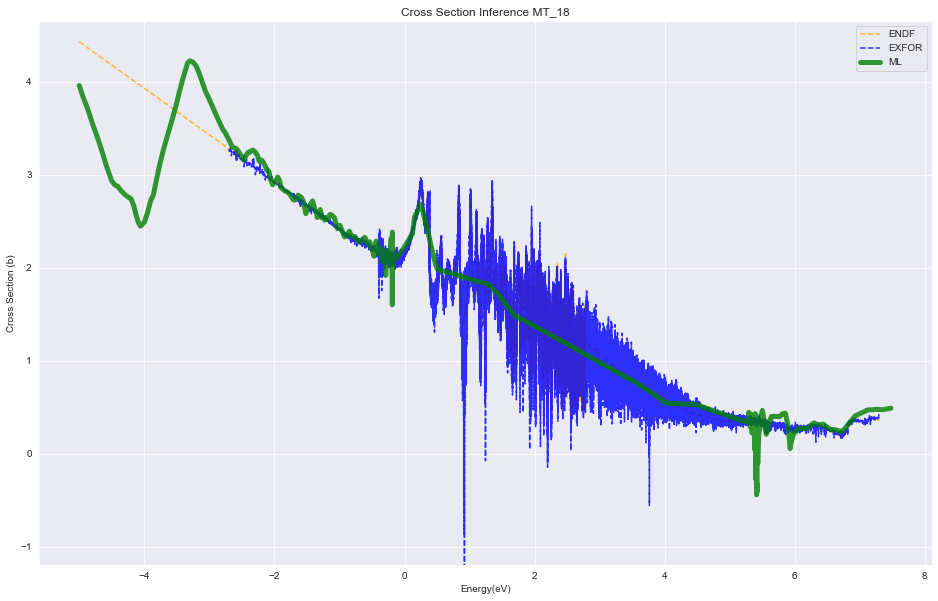

EXFOR VS ML: Original Data
The MSE is:  0.06665776977244131
The MAE is:  0.18711783798676415
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Tiny_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


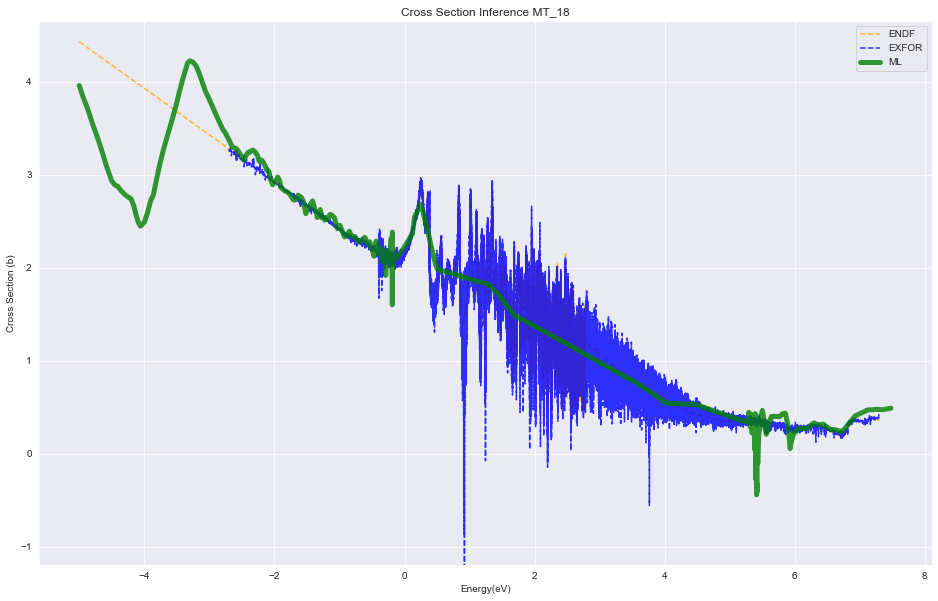

EXFOR VS ML: Original Data
The MSE is:  0.06665776977244131
The MAE is:  0.18711783798676415
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Tiny_Plateau
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


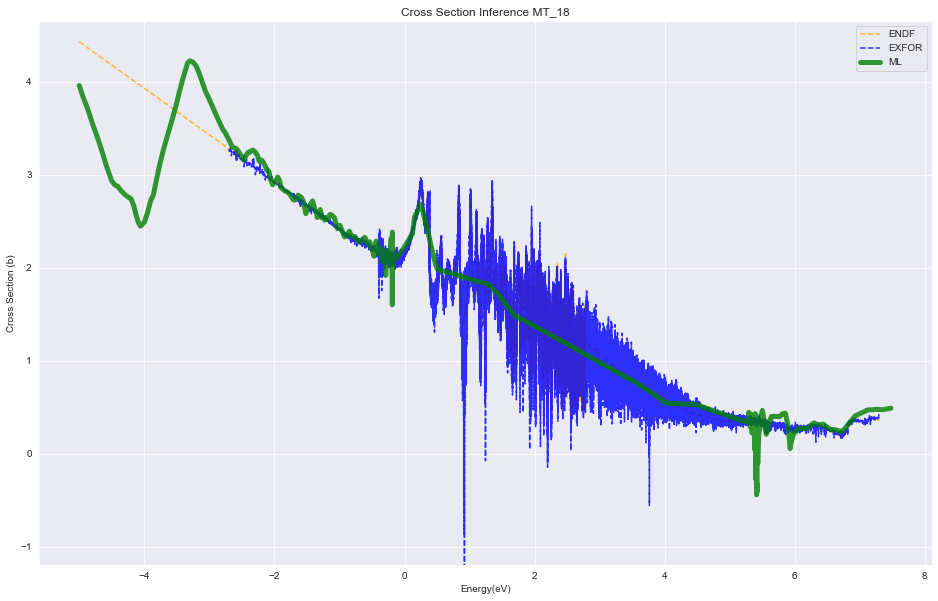

EXFOR VS ML: Original Data
The MSE is:  0.06665776977244131
The MAE is:  0.18711783798676415
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Medium_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


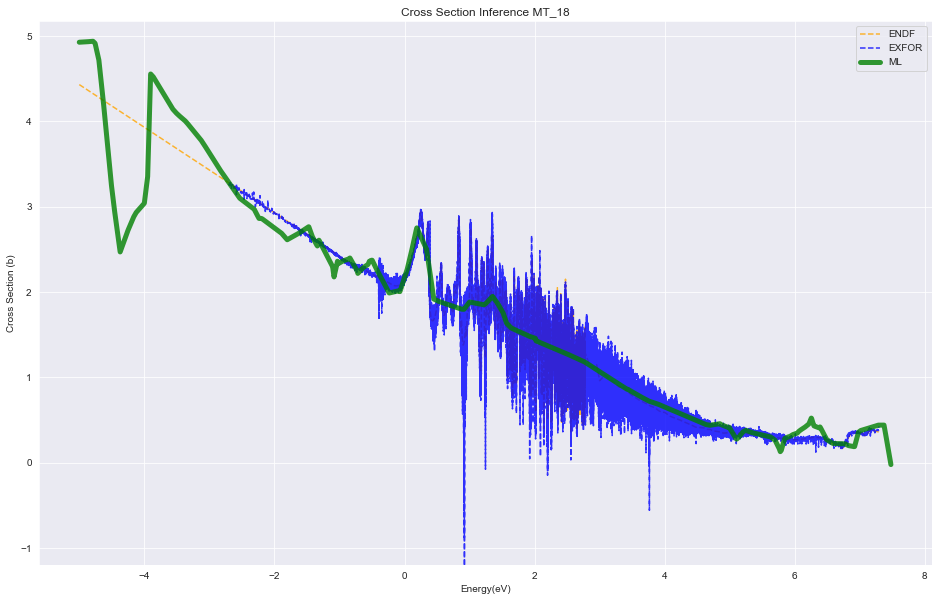

EXFOR VS ML: Original Data
The MSE is:  0.06513132822382332
The MAE is:  0.18622933331304772
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Large_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


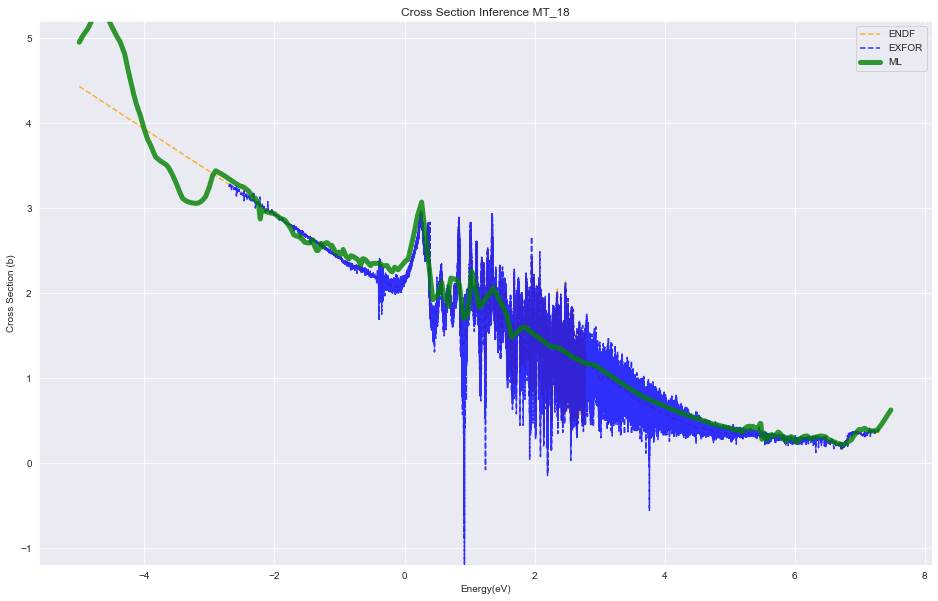

EXFOR VS ML: Original Data
The MSE is:  0.06660250751437702
The MAE is:  0.19668755575616756
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
L2_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


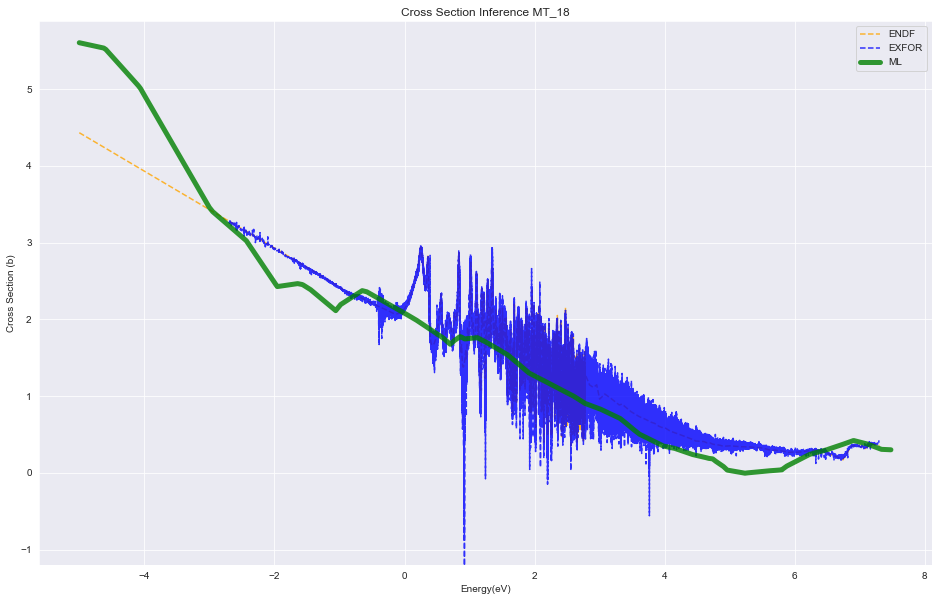

EXFOR VS ML: Original Data
The MSE is:  0.10456721113395992
The MAE is:  0.2617868468547031
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Dropout_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


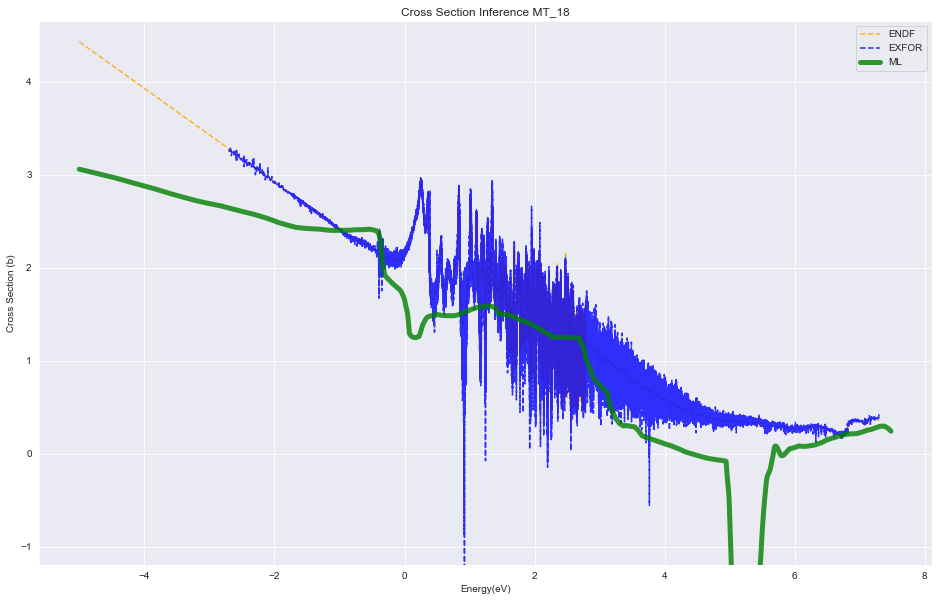

EXFOR VS ML: Original Data
The MSE is:  0.2690679836792549
The MAE is:  0.39801544743708683
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Combined_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


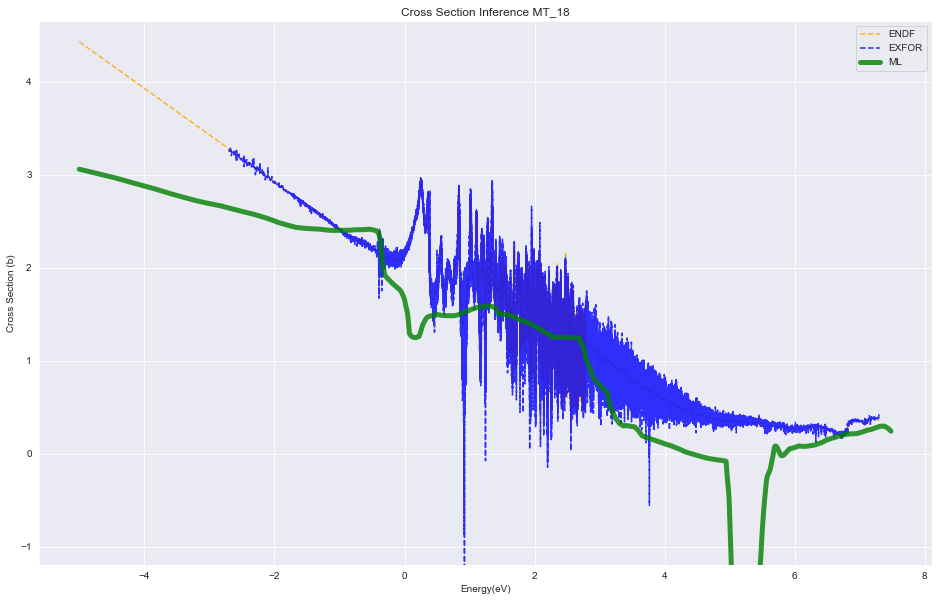

EXFOR VS ML: Original Data
The MSE is:  0.2690679836792549
The MAE is:  0.39801544743708683
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128


In [142]:
for i in histories.keys():
    print(i)
    run_uranium(histories[i].model)

Tiny
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


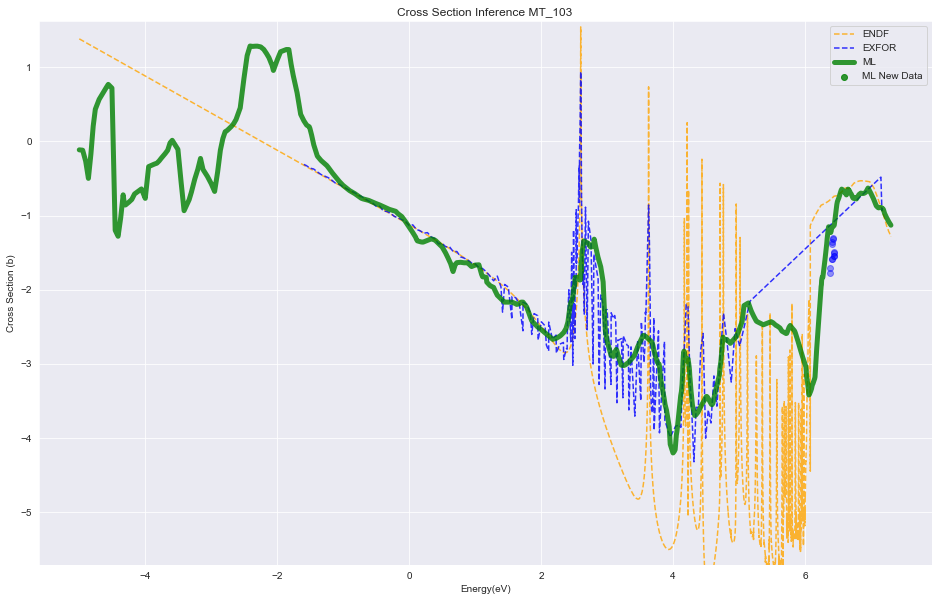

EXFOR VS ML: Original Data
The MSE is:  0.3882098896968545
The MAE is:  0.397416340056491
EXFOR VS ML: New Data
The MSE is:  7237.199981544659
The MAE is:  85.07159067280793
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Tiny_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


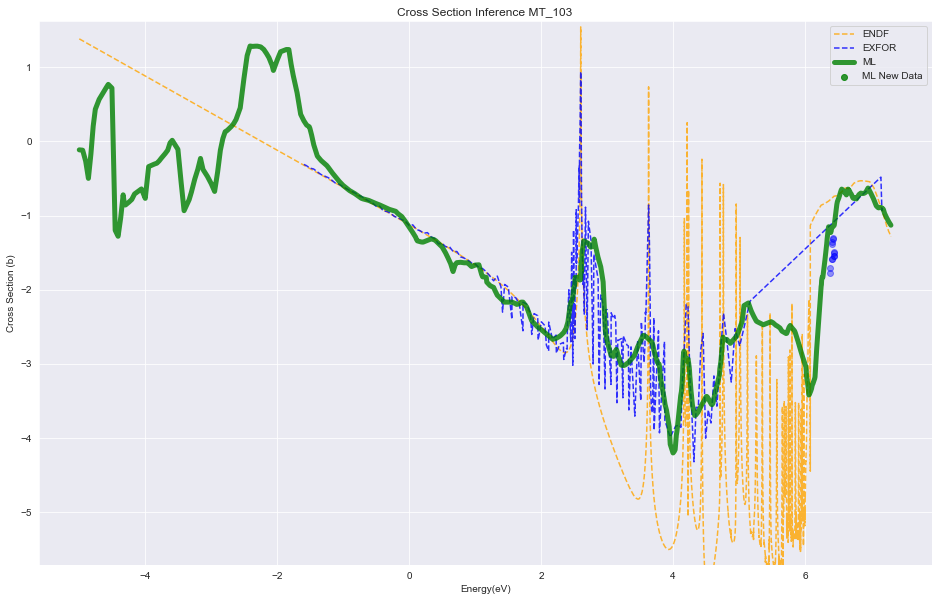

EXFOR VS ML: Original Data
The MSE is:  0.3882098896968545
The MAE is:  0.397416340056491
EXFOR VS ML: New Data
The MSE is:  7237.199981544659
The MAE is:  85.07159067280793
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Tiny_Plateau
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


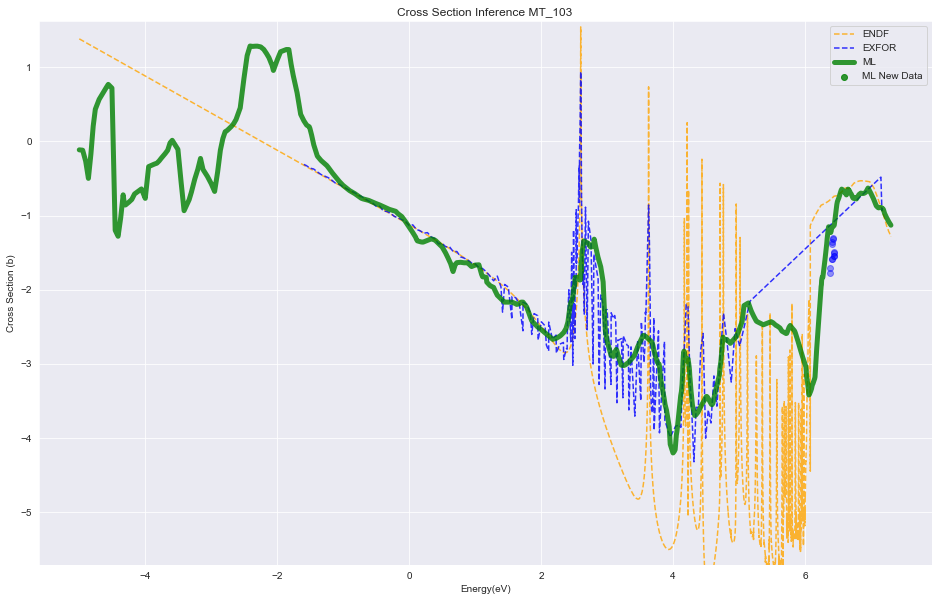

EXFOR VS ML: Original Data
The MSE is:  0.3882098896968545
The MAE is:  0.397416340056491
EXFOR VS ML: New Data
The MSE is:  7237.199981544659
The MAE is:  85.07159067280793
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Medium_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


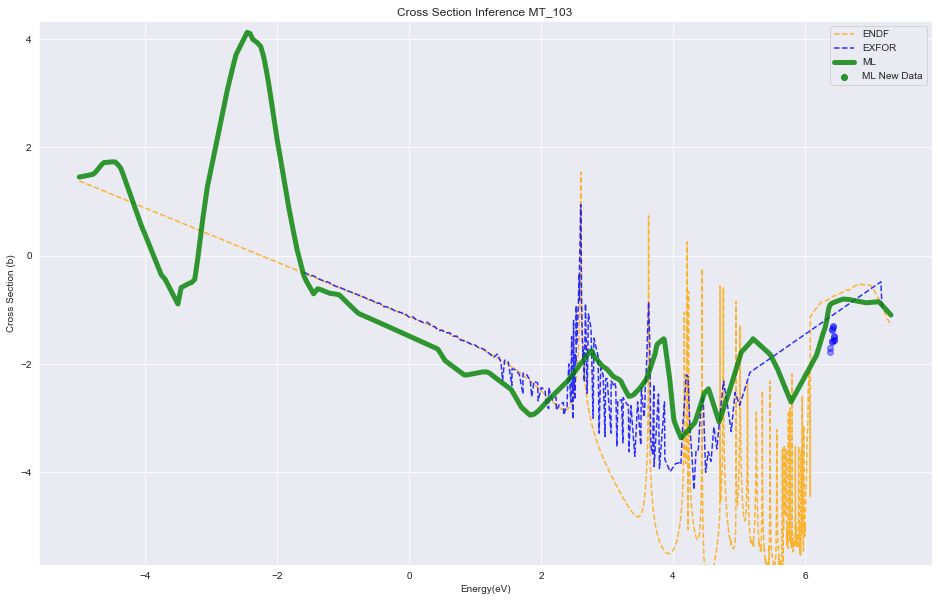

EXFOR VS ML: Original Data
The MSE is:  0.6226450098156531
The MAE is:  0.5742311229393438
EXFOR VS ML: New Data
The MSE is:  49563.72815624442
The MAE is:  222.62907766215298
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Large_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


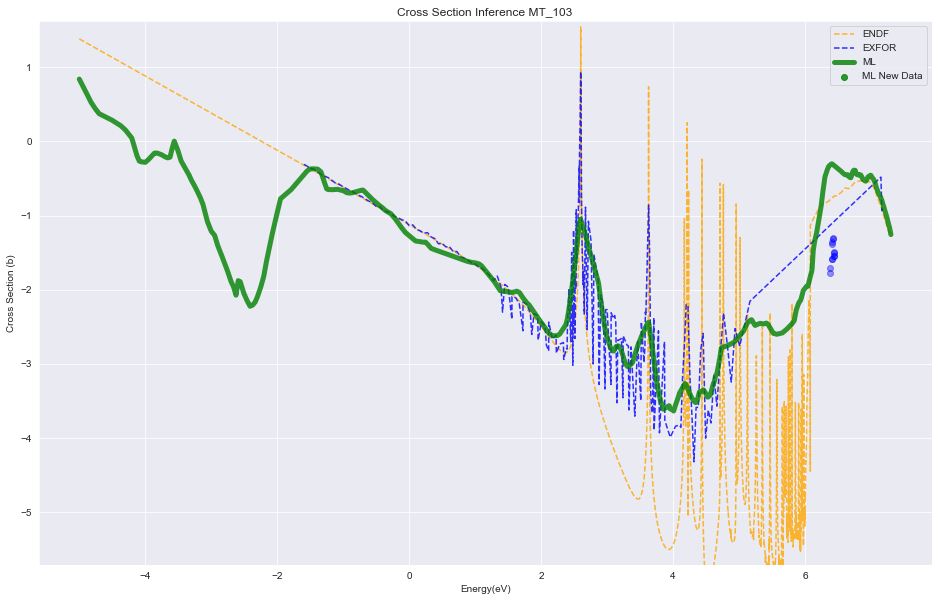

EXFOR VS ML: Original Data
The MSE is:  0.26299793223781315
The MAE is:  0.35155699120298634
EXFOR VS ML: New Data
The MSE is:  8850.199475446547
The MAE is:  94.07537230936391
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
L2_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


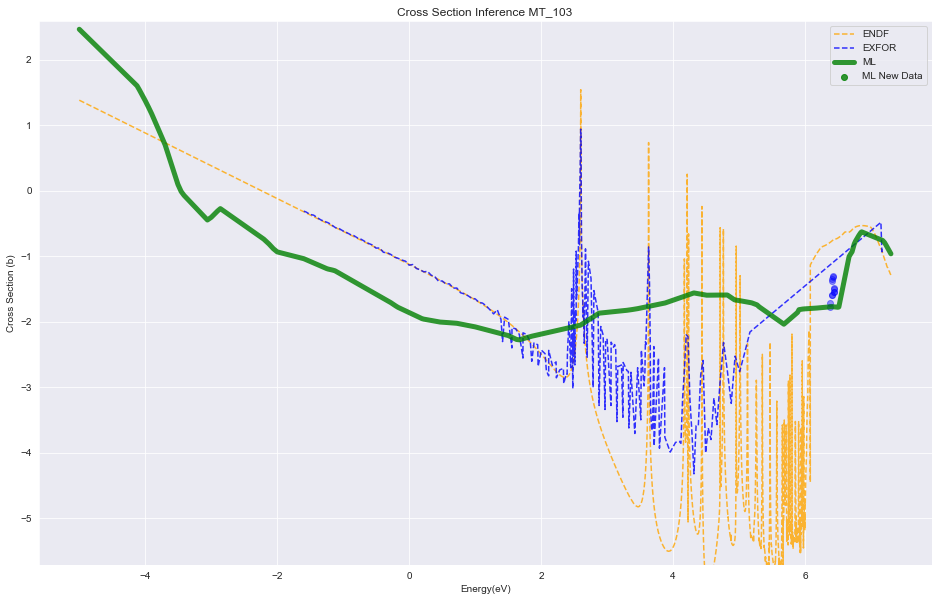

EXFOR VS ML: Original Data
The MSE is:  1.0938756815959234
The MAE is:  0.8336582843095587
EXFOR VS ML: New Data
The MSE is:  21239.36602994867
The MAE is:  145.73726247660613
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Dropout_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


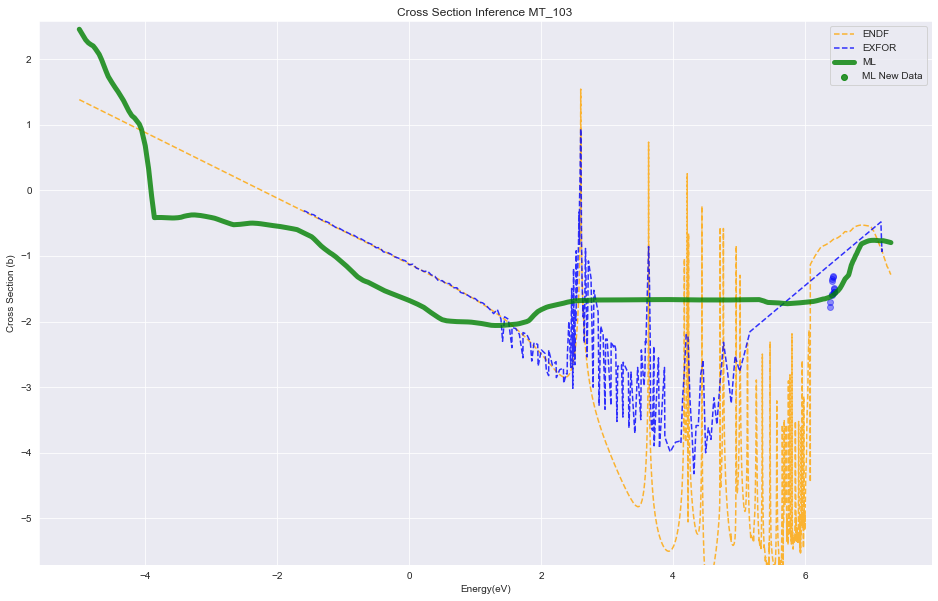

EXFOR VS ML: Original Data
The MSE is:  1.0388435873650184
The MAE is:  0.8180099744453403
EXFOR VS ML: New Data
The MSE is:  908.9561553473413
The MAE is:  30.14850132751172
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Combined_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)


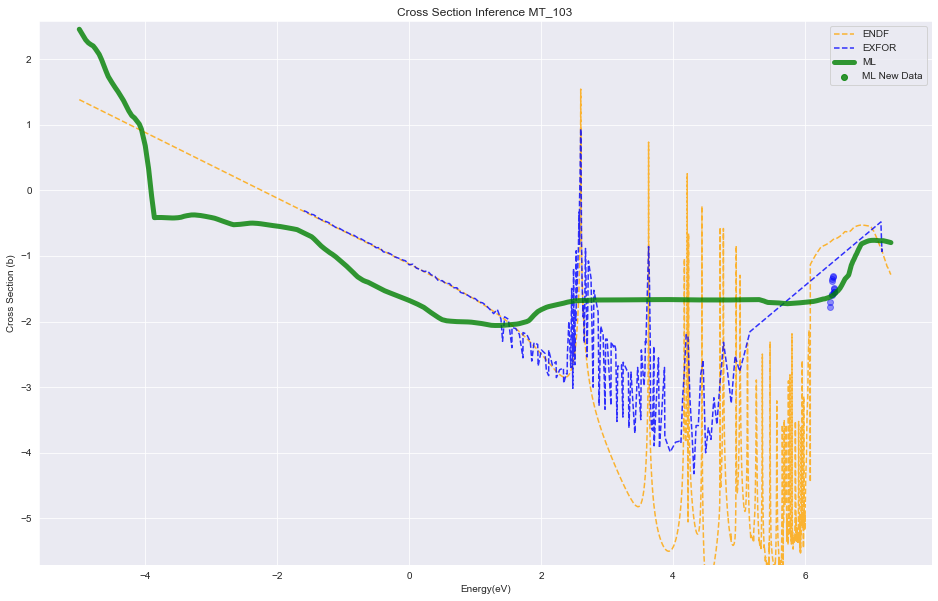

EXFOR VS ML: Original Data
The MSE is:  1.0388435873650184
The MAE is:  0.8180099744453403
EXFOR VS ML: New Data
The MSE is:  908.9561553473413
The MAE is:  30.14850132751172
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888


In [143]:
for i in histories.keys():
    print(i)
    run_chlorine(histories[i].model)

# Trying Hyperparameter Tuning

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [71]:
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4, 8, 16])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4, 8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_MSE = 'mse'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2, HP_DROPOUT, HP_L2, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_MSE, display_name='Mean Squared Error')])

In [ ]:
def train_test_model(hparams):
    model = tf.keras.Sequential([
        layers.Dense(hparams[HP_NUM_UNITS1], activation='relu'),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], activation='relu'),
        layers.Dense(1)])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_ds,
              validation_data=val_ds,
              epochs=5)
    _, accuracy = model.evaluate(val_ds)
    
    model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=(x_test, y_test),
        callbacks=get_callbacks(name, lr_method=lr_method),
        verbose=1, 
        initial_epoch=initial_epoch) 
    
    _, accuracy = model.evaluate(val_ds)
    return accuracy

In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    
                    hparams = {
                      HP_NUM_UNITS1: num_units1,
                      HP_NUM_UNITS2: num_units2,
                      HP_DROPOUT: dropout_rate,
                      HP_L2: l2,
                      HP_OPTIMIZER: optimizer

                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_MSE = 'mse'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_MSE, display_name='Mean Squared Error')])

In [ ]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),
        tf.keras.layers.Dense(8, activation=tf.nn.relu),
        tf.keras.layers.Dense(1),
    ])
    
    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
  )

    model.fit(x_train, y_train, epochs=5) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy

In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
# model.fit(
#     ...,
#     callbacks=[
#         tf.keras.callbacks.TensorBoard(logdir),  # log metrics
#         hp.KerasCallback(logdir, hparams),  # log hparams
#     ],
# )

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1
